# Pneumonia and COVID-19 Detection with Neural Networks

## Introduction (UPDATE, just copied from proposal)

One major problem in the world today is that the costs and wait times associated with health care are extremely high and continually increasing.  Delayed diagnosis can prolong the time that it takes to get patients the proper treatment, and can put them at serious risk.  Traditionally, diseases could only be properly diagnosed by a trained medical professional, and many of these doctors have long backlogs that can get in the way of diagnosing a disease quickly and accurately.  We see an opportunity to mitigate some of the inefficiencies associated with diagnosing a patient by training a machine-learning algorithm to do a fast and efficient screening.  The more ambitious goal would be to develop a machine-learning algorithm that could fully automate the process and achieve 100% accuracy.  We do believe however, that we could substantially reduce wait times and costs associated with diagnosing a disease by automating the process even partially - perhaps by training an algorithm to do an initial screening of many patients and to flag any patients that need further review from a trained professional.

There are several important questions to explore when considering this problem.  First, is it even possible to train a machine-learning algorithm to screen very similar X-Ray images of thousands of different patients?  Will the algorithm be able to achieve the resolution necessary to differentiate between minute features in the images that could potentially impact the diagnosis?  Will it be able to achieve a high level of accuracy that doctors can trust?  All of these questions are critically important because we are dealing with human lives, and even a single mis-diagnosis could have extreme consequences and bring the validity of machine learning in health care into question.  We also need to ask what type of model might be best as the foundation for this type of image classification machine-learning algorithm.  Others have attempted to solve this problem, mostly by using Convolutional Neural Networks.  We will aim to build on these past attempts through testing our neural network with a second dataset composed of similar X-Ray images from COVID-19 patients. 

In [1]:
# Load general libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [86]:
!python -V 

Python 3.7.1


In [87]:
!tensorflow -V

'tensorflow' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Install libraries that may need separate installation
!pip install imutils
!pip3 install opencv-python

  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25853 sha256=92d3801529adec2aa7fb7683e3e8396c9e5adba6d51ab302eca38ca40392a885
  Stored in directory: C:\Users\irene.hamliu\AppData\Local\pip\Cache\wheels\16\84\1f\bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\irene.hamliu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [11]:
!pip3 install np_utils

  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57131 sha256=ebbd83651f6bac2ec7685fece361ab25a5fd815926760afeee712400b00b3d78
  Stored in directory: C:\Users\irene.hamliu\AppData\Local\pip\Cache\wheels\92\4b\81\206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [14]:
!pip3 install opencv-python

You should consider upgrading via the 'C:\Users\irene.hamliu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [20]:
!pip install opencv-python

In [22]:
# Load Machine learning libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import argparse
import os
import np_utils

import cv2
from imutils import paths

## Datasets ( update, just copied from proposal)

We will be using the “Chest X-Ray Images (Pneumonia)” dataset (IMAGE 1c in the project datasets guide) for this project. This dataset provides us with images clearly tabulated for us to test, train and validate our model. It is worth noting that the data is somewhat limited since it doesn’t provide metadata about the individual images (e.g. exact age and size of patient, or other health factors/indications) other than the presence of pneumonia or not. If we wanted to derive the most accurate algorithm, it would probably be helpful to have more context around each of the images. 

As we mentioned, the images are organized into three subdirectories named “test”, “train” and “validate” which each have two subdirectories named “NORMAL” and “PNEUMONIA”. Clearly this dataset was created with machine learning in mind, and it is ideal for the scope of our problem. We will add the dataset, “COVID-19 Chest X-Ray Dataset,” which contains X-Ray images of patients with COVID-19 and other viral and bacterial pneumonias. By including this set, we can see how well our neural network stacks against a different population and can see if there is any generalization possible.


In [4]:
# Load current directory and dataset paths 
cdir = sys.path[0]
pneumonia_path = "Chest_XRay_Data"
covid_path = "COVID19_Data"

# Non-COVID-19 Pneumonia Detection

### Reading in Pneumonia Data 

In [23]:
# set labels between sick and healthy patients
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    """ Function for loading images from a folder.
    Args:
        data_dir: path/directory for the data.
    Returns:
        Numpy array of the folder's images rescaled to 150x150 pixels, in the form of [img values,label]
    """
    # reduce image size for quicker loading
    img_size = 150
    
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(data)

In [26]:
# Load pneumonia data into arrays
train = get_training_data(os.path.sep.join([cdir,'Chest_XRay_Data/chest_xray/train']))
test = get_training_data(os.path.sep.join([cdir,'Chest_XRay_Data/chest_xray/test']))
val = get_training_data(os.path.sep.join([cdir,'Chest_XRay_Data/chest_xray/val']))

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [27]:
# Check the format of an image
train[0]

array([array([[18, 28, 29, ..., 13,  7,  1],
       [21, 24, 29, ..., 14,  9,  3],
       [22, 26, 32, ..., 16,  9,  2],
       ...,
       [10,  9,  8, ..., 15, 15, 15],
       [10, 10,  8, ..., 15, 15, 15],
       [10, 10,  8, ..., 15, 15, 15]], dtype=uint8),
       'PNEUMONIA'], dtype=object)

In [28]:
# Format as dataframes
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])
val_df = pd.DataFrame(val, columns = ['image', 'label'])

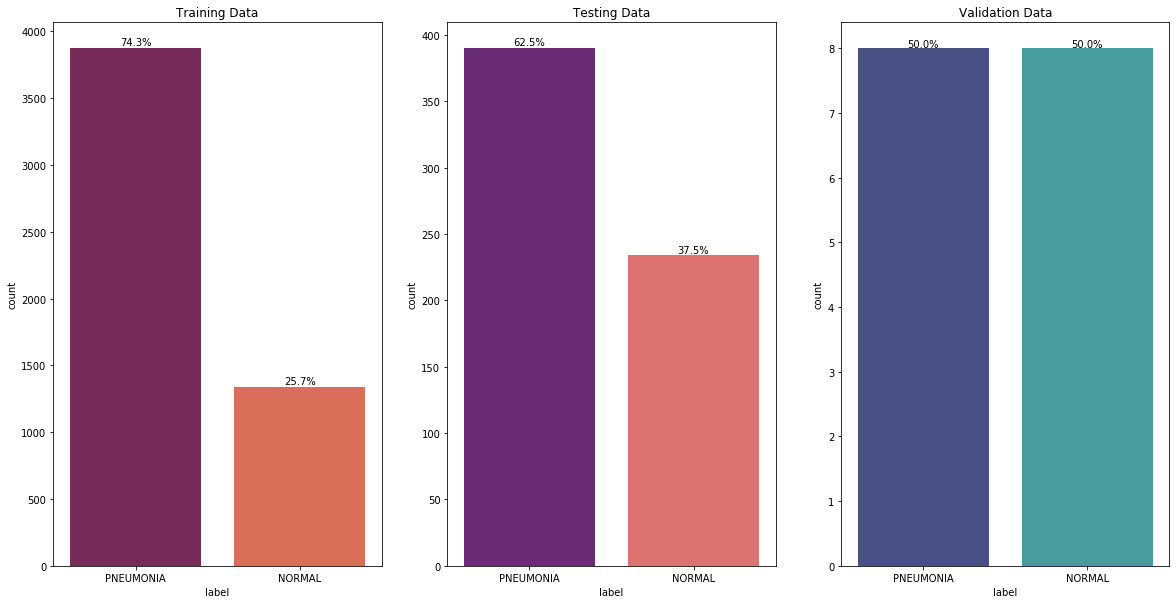

In [29]:
# Plot frequencies of pneumonia vs normal cases in the training, testing, and validation datasets
plt.figure(figsize = (20,10))

# Training
plt.subplot(1,3,1)
total = float(len(train_df))
ax = sns.countplot(train_df['label'], palette = 'rocket') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20 ,
            '{:1.1%}'.format(height/total),
            ha="center")
plt.title('Training Data')

# Testing
plt.subplot(1,3,2)
total = float(len(test_df))
ax = sns.countplot(test_df['label'], palette = 'magma') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            '{:1.1%}'.format(height/total),
            ha="center") 
plt.title('Testing Data')

# Validate
plt.subplot(1,3,3)
total = float(len(val_df))
ax = sns.countplot(val_df['label'], palette = 'mako') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + .01,
            '{:1.1%}'.format(height/total),
            ha="center") 
noprint = plt.title('Validation Data')

Both the test and train datasets are imbalanced, with greater numbers of patients with pneumonia. However, they both have roughly the same percent of pneumonia to normal images between the two sets. The validation set has equal numbers of pneumonia and normal cases.

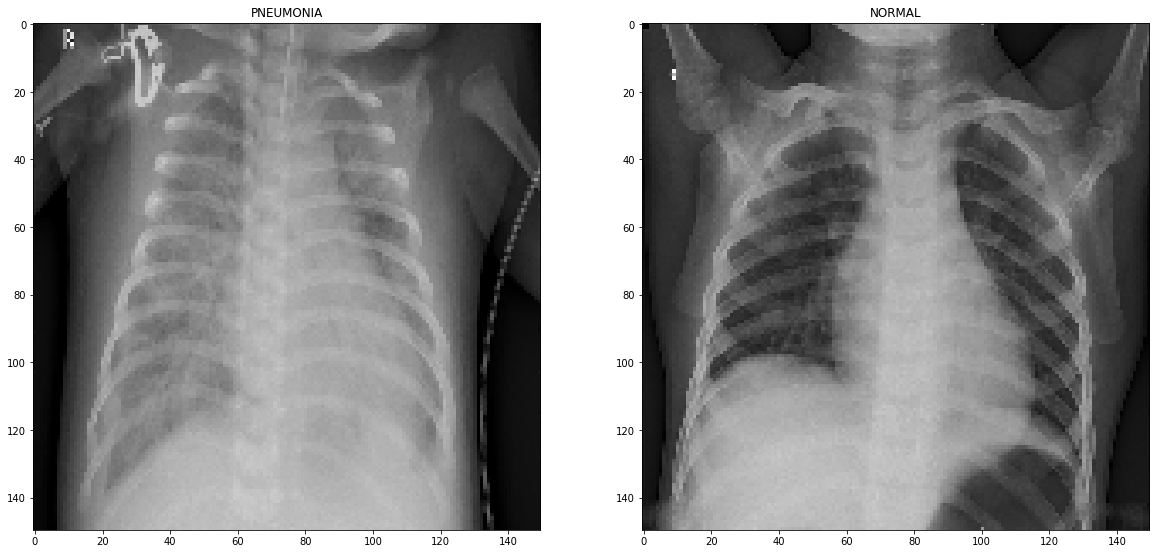

In [30]:
plt.figure(figsize = (20,10))

# example image of 'Pneumonia' case
plt.subplot(1,2,1)
plt.imshow(train[0][0], cmap='gray')
plt.title(train[0][1])

# example image of 'Normal' case
plt.subplot(1,2,2)
plt.imshow(train[-1][0], cmap='gray')
noshow = plt.title(train[-1][1])

### Preprocessing Pneumonia

In [31]:
def binary_label(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

# Split datasets into x, y
def split_x_y(dataset):
    """Splits a dataset into it's features and labels
    Args:
        dataset: a numpy array in which each datum has two columns that represent it's features and labels.
    Returns:
        A function that returns split X and y data in numpy arrays.
    """
    X = []
    y = []
    for feature, label in dataset:
        X.append(feature)
        y.append(binary_label(label))
    return(np.array(X), np.array(y))

In [32]:
# Split the datasets
X_train, y_train = split_x_y(train)
X_test, y_test = split_x_y(test)
X_val, y_val = split_x_y(val)

### Next steps: based on https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/

Before we train a CNN model, let’s build a basic Fully Connected Neural Network for the dataset. The basic steps to build an image classification model using a neural network are:

1) Resize the input image dimensions

2) Normalize the image pixel values (divide by 255)

3) One-Hot Encode the categorical column

4) Build a model architecture (Sequential) with Dense layers

5) Train the model and make predictions

In [79]:
def image_preprocessing(X_test_data,x_train_data):
    #this function resizes and normalizes the images
    img_size = 150
    # Resizing the images
    x_train_data = x_train_data.reshape(-1, img_size, img_size, 1)
    X_test_data = X_test_data.reshape(-1, img_size, img_size, 1)
    
    x_train_data = x_train_data.astype('float32')
    X_test_data = X_test_data.astype('float32')
    # normalizing the data to help with the training
    x_train_data /= 255
    X_test_data /= 255
    
    return x_train_data,X_test_data
    

In [33]:
img_size = 150

# Resizing the images
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [34]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255
X_val /= 255

X_train[0]

array([[[0.07058824],
        [0.10980392],
        [0.11372549],
        ...,
        [0.05098039],
        [0.02745098],
        [0.00392157]],

       [[0.08235294],
        [0.09411765],
        [0.11372549],
        ...,
        [0.05490196],
        [0.03529412],
        [0.01176471]],

       [[0.08627451],
        [0.10196079],
        [0.1254902 ],
        ...,
        [0.0627451 ],
        [0.03529412],
        [0.00784314]],

       ...,

       [[0.03921569],
        [0.03529412],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]]], dtype=float32)

In [37]:
# one-hot encoding the labels
from tensorflow.keras.utils import to_categorical

n_classes = 2
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (5216,)
Shape after one-hot encoding:  (5216, 2)


In [84]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(16, kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same', 
                 activation='relu', 
                 input_shape=(150, 150, 1)))

model.add(MaxPool2D(pool_size=(2,2)))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(100, activation='relu'))

# output layer
model.add(Dense(2, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               9000100   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 9,000,462
Trainable params: 9,000,462
Non-trainable params: 0
_________________________________________________________________
Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 36s 7ms

In [ ]:
### STEPS FORWARD ---> visualize loss and accuracy
process covid data
fit model to covid data

### Reading in COVID-19 Metadata

In [44]:
# construct the path to the COVID metadata CSV file and load it
covid_dataset_path = os.path.sep.join([covid_path, "metadata.csv"])
covid_meta = pd.read_csv(csvPath)

In [45]:
covid_meta.head(3)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


# COVID-19 Pneumonia Detection
Covid data from: https://www.kaggle.com/khoongweihao/covid19-xray-dataset-train-test-sets

In [70]:
covid_path = "xray_dataset_covid19"
# Load covid data into arrays
train_covid = get_training_data(os.path.sep.join([cdir,'xray_dataset_covid19/train']))
test_covid = get_training_data(os.path.sep.join([cdir,'xray_dataset_covid19/test']))

In [72]:
# Format as dataframes
train_df_covid = pd.DataFrame(train_covid, columns=['image', 'label'])
test_df_covid = pd.DataFrame(test_covid, columns = ['image', 'label'])

Checking out the covid19 data

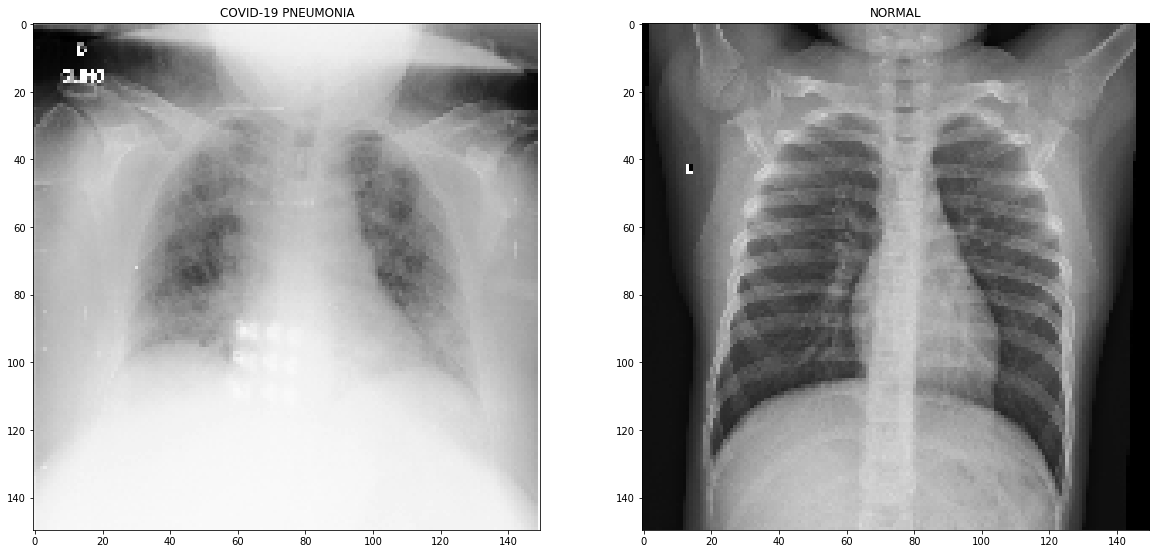

In [76]:
plt.figure(figsize = (20,10))

# example image of 'Pneumonia' case
plt.subplot(1,2,1)
plt.imshow(train_covid[0][0], cmap='gray')
plt.title('COVID-19 '+ train_covid[0][1])

# example image of 'Normal' case
plt.subplot(1,2,2)
plt.imshow(train_covid[-1][0], cmap='gray')
noshow = plt.title(train_covid[-1][1])

The model has been trained on Pneumonia data, without distinction between COVID-19 pneunomia or otherwise... So we are going to use a second model to classify between Normal and COVID-19 Pneumonia:

In [78]:
# Split the datasets
X_train_covid, y_train_covid = split_x_y(train_covid)
X_test_covid, y_test_covid = split_x_y(test_covid)

In [80]:
#processing images to resize and normalize
image_preprocessing(X_test_covid, X_train)

(array([[[[2.7681663e-04],
          [4.3060363e-04],
          [4.4598232e-04],
          ...,
          [1.9992310e-04],
          [1.0765091e-04],
          [1.5378702e-05]],
 
         [[3.2295272e-04],
          [3.6908881e-04],
          [4.4598232e-04],
          ...,
          [2.1530181e-04],
          [1.3840832e-04],
          [4.6136101e-05]],
 
         [[3.3833142e-04],
          [3.9984621e-04],
          [4.9211847e-04],
          ...,
          [2.4605924e-04],
          [1.3840832e-04],
          [3.0757405e-05]],
 
         ...,
 
         [[1.5378701e-04],
          [1.3840832e-04],
          [1.2302962e-04],
          ...,
          [2.3068051e-04],
          [2.3068051e-04],
          [2.3068051e-04]],
 
         [[1.5378701e-04],
          [1.5378701e-04],
          [1.2302962e-04],
          ...,
          [2.3068051e-04],
          [2.3068051e-04],
          [2.3068051e-04]],
 
         [[1.5378701e-04],
          [1.5378701e-04],
          [1.2302962e-04],
   

In [81]:
# one-hot encoding the labels
n_classes = 2
print("Shape before one-hot encoding: ", y_train_covid.shape)
Y_train_covid = to_categorical(y_train_covid)
Y_test_covid = to_categorical(y_test_covid)
print("Shape after one-hot encoding: ", Y_train_covid.shape)

Shape before one-hot encoding:  (148,)
Shape after one-hot encoding:  (148, 2)


## COVID 19 pneumonia model

In [88]:
# building a linear stack of layers with the sequential model
model_covid= Sequential()

# convolutional layer
model_covid.add(Conv2D(16, kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same', 
                 activation='relu', 
                 input_shape=(148, 150, 150)))

model_covid.add(MaxPool2D(pool_size=(2,2)))

# flatten output of conv
model_covid.add(Flatten())

# hidden layer
model_covid.add(Dense(100, activation='relu'))

# output layer
model_covid.add(Dense(2, activation='softmax'))

# compiling the sequential model
model_covid.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model_covid.summary()

# training the model for 10 epochs
model_covid.fit(X_train_covid, Y_train_covid, batch_size=64, epochs=10, validation_data=(X_test_covid, Y_test_covid))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 150, 16)      21616     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 75, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 88800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               8880100   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 8,901,918
Trainable params: 8,901,918
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected conv2d_3_input to have 4 dimensions, but got array with shape (148, 150, 150)